## Data loading for IEEE data 


In [4]:
# Link for Kaggle
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia healthy samples 


In [186]:
from PIL import Image
from os.path import join
from skimage.io import imread, imsave
from skimage import img_as_ubyte
from torch import nn
from torch.nn.modules.linear import Linear
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import os,sys,os.path
import pandas as pd
import pickle
import skimage
import glob
import collections
import pprint
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
import skimage.transform
import warnings
import tarfile



In [209]:
default_pathologies = [  'Atelectasis',
                 'Consolidation',
                 'Infiltration',
                 'Pneumothorax',
                 'Edema',
                 'Emphysema',
                 'Fibrosis',
                 'Effusion',
                 'Pneumonia',
                 'Pleural_Thickening',
                 'Cardiomegaly',
                 'Nodule',
                 'Mass',
                 'Hernia',
                 'Lung Lesion',
                 'Fracture',
                 'Lung Opacity',
                 'Enlarged Cardiomediastinum'
                ]

thispath = os.path.dirname(os.path.realpath('__file__'))

def normalize(sample, maxval):
    """Scales images to be roughly [-1024 1024]."""
    sample = (2 * (sample.astype(np.float32) / maxval) - 1.) * 1024
    #sample = sample / np.std(sample)
    return sample

def relabel_dataset(pathologies, dataset):
    """
    Reorder, remove, or add (nans) to a dataset's labels.
    Use this to align with the output of a network.
    """
    will_drop = set(dataset.pathologies).difference(pathologies)
    if will_drop != set():
        print("{} will be dropped".forplot
              (will_drop))
    new_labels = []
    dataset.pathologies = list(dataset.pathologies)
    for pathology in pathologies:
        if pathology in dataset.pathologies:
            pathology_idx = dataset.pathologies.index(pathology)
            new_labels.append(dataset.labels[:,pathology_idx])
        else:
            print("{} doesn't exist. Adding nans instead.".format(pathology))
            values = np.empty(dataset.labels.shape[0])
            values.fill(np.nan)
            new_labels.append(values)
    new_labels = np.asarray(new_labels).T
    
    dataset.labels = new_labels
    dataset.pathologies = pathologies

class Dataset():
    def __init__(self):
        pass
    def totals(self):
        counts = [dict(collections.Counter(items[~np.isnan(items)]).most_common()) for items in self.labels.T]
        return dict(zip(self.pathologies,counts))
    def check_paths_exist(self):
        if not os.path.isdir(self.imgpath):
            raise Exception("imgpath must be a directory")
        if not os.path.isfile(self.csvpath):
            raise Exception("csvpath must be a file")
        
    
class Merge_Dataset(Dataset):
    def __init__(self, datasets, seed=0, label_concat=False):
        super(Merge_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.datasets = datasets
        self.length = 0
        self.pathologies = datasets[0].pathologies
        self.which_dataset = np.zeros(0)
        self.offset = np.zeros(0)
        currentoffset = 0
        for i, dataset in enumerate(datasets):
            self.which_dataset = np.concatenate([self.which_dataset, np.zeros(len(dataset))+i])
            self.length += len(dataset)
            self.offset = np.concatenate([self.offset, np.zeros(len(dataset))+currentoffset])
            currentoffset += len(dataset)
            if dataset.pathologies != self.pathologies:
                raise Exception("incorrect pathology alignment")
                
        if hasattr(datasets[0], 'labels'):
            self.labels = np.concatenate([d.labels for d in datasets])
        else:
            print("WARN: not adding .labels")
        
        self.which_dataset = self.which_dataset.astype(int)
        
        if label_concat:
            new_labels = np.zeros([self.labels.shape[0], self.labels.shape[1]*len(datasets)])*np.nan
            for i, shift in enumerate(self.which_dataset):
                size = self.labels.shape[1]
                new_labels[i,shift*size:shift*size+size] = self.labels[i]
            self.labels = new_labels
            
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={}".format(len(self))
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        item = self.datasets[int(self.which_dataset[idx])][idx  - int(self.offset[idx])]
        item["lab"] = self.labels[idx]
        item["source"] = self.which_dataset[idx]
        return item
        
class FilterDataset(Dataset):
    def __init__(self, dataset, labels=None):
        super(FilterDataset, self).__init__()
        self.dataset = dataset
        self.pathologies = dataset.pathologies
        
#         self.idxs = np.where(np.nansum(dataset.labels, axis=1) > 0)[0]
        
        self.idxs = []
        if labels:
            for label in labels:
                print("filtering for ", label)
                
                self.idxs += list(np.where(dataset.labels[:,dataset.pathologies.index(label)] == 1)[0])
#             singlelabel = np.nanargmax(dataset.labels[self.idxs], axis=1)
#             subset = [k in labels for k in singlelabel]
#             self.idxs = self.idxs[np.array(subset)]
        
        self.labels = self.dataset.labels[self.idxs]
                
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={}".format(len(self))
    
    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        return self.dataset[self.idxs[idx]]

class SubsetDataset(Dataset):
    def __init__(self, dataset, idxs=None):
        super(SubsetDataset, self).__init__()
        self.dataset = dataset
        self.pathologies = dataset.pathologies
        
        self.idxs = idxs
        
        self.labels = self.dataset.labels[self.idxs]
        self.csv = self.dataset.csv.iloc[self.idxs]
                
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={}".format(len(self))
    
    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        return self.dataset[self.idxs[idx]]

    
class NIH_Dataset(Dataset):
    """
    NIH ChestX-ray8 dataset
    Dataset release website:
    https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community
    
    Download full size images here:
    https://academictorrents.com/details/557481faacd824c83fbf57dcf7b6da9383b3235a
    
    Download resized (224x224) images here:
    https://academictorrents.com/details/e615d3aebce373f1dc8bd9d11064da55bdadede0
    """
    def __init__(self, imgpath, 
                 csvpath=os.path.join(thispath, "Data_Entry_2017.csv.gz"), 
                 views=["PA"],
                 transform=None, 
                 data_aug=None, 
                 nrows=None, 
                 seed=0,
                 pure_labels=False, 
                 unique_patients=True):
        
        super(NIH_Dataset, self).__init__()

        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.imgpath = imgpath
        self.csvpath = csvpath
        self.transform = transform
        self.data_aug = data_aug
        
        self.pathologies = ["Atelectasis", "Consolidation", "Infiltration",
                            "Pneumothorax", "Edema", "Emphysema", "Fibrosis",
                            "Effusion", "Pneumonia", "Pleural_Thickening",
                            "Cardiomegaly", "Nodule", "Mass", "Hernia"]
        
        self.pathologies = sorted(self.pathologies)

        # Load data
        self.check_paths_exist()
        self.csv = pd.read_csv(self.csvpath, nrows=nrows)
        self.MAXVAL = 255  # Range [0 255]
        
        if type(views) is not list:
            views = [views]
        self.views = views
        # Remove images with view position other than specified
        self.csv = self.csv[self.csv['View Position'].isin(self.views)]

        # Remove multi-finding images.
        if pure_labels:
            self.csv = self.csv[~self.csv["Finding Labels"].str.contains("\|")]

        if unique_patients:
            self.csv = self.csv.groupby("Patient ID").first().reset_index()
            
        # Get our classes.
        self.labels = []
        for pathology in self.pathologies:
            self.labels.append(self.csv["Finding Labels"].str.contains(pathology).values)
            
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)

    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={} views={}".format(len(self), self.views)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imgid = self.csv['Image Index'].iloc[idx]
        img_path = os.path.join(self.imgpath, imgid)
        #print(img_path)
        img = imread(img_path)
        img = normalize(img, self.MAXVAL)  

        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]                    
                               
        if self.transform is not None:
            img = self.transform(img)

        if self.data_aug is not None:
            img = self.data_aug(img)
            
        return {"img":img, "lab":self.labels[idx], "idx":idx}
    
class Kaggle_Dataset(Dataset):
    """
    RSNA Pneumonia Detection Challenge
    
    Challenge site:
    https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
    
    JPG files stored here:
    https://academictorrents.com/details/95588a735c9ae4d123f3ca408e56570409bcf2a9
    """
    def __init__(self, 
                 imgpath, 
                 csvpath=os.path.join(thispath, "kaggle_stage_2_train_labels.csv.zip"),
                 dicomcsvpath=os.path.join(thispath, "kaggle_stage_2_train_images_dicom_headers.csv.gz"),
                 views=["PA"],
                 transform=None, 
                 data_aug=None, 
                 nrows=None, 
                 seed=0,
                 pure_labels=False, 
                 unique_patients=True):

        super(Kaggle_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.imgpath = imgpath
        self.transform = transform
        self.data_aug = data_aug
        
        self.pathologies = ["Pneumonia", "Lung Opacity"]
        
        self.pathologies = sorted(self.pathologies)

        # Load data
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath, nrows=nrows)
        
        self.dicomcsvpath = dicomcsvpath
        self.dicomcsv = pd.read_csv(self.dicomcsvpath, nrows=nrows, index_col="PatientID")
        
        self.csv = self.csv.join(self.dicomcsv, on="patientId")
        
        self.MAXVAL = 255  # Range [0 255]
        
        if type(views) is not list:
            views = [views]
        self.views = views
        # Remove images with view position other than specified
        self.csv = self.csv[self.csv['ViewPosition'].isin(self.views)]

        # Get our classes.
        self.labels = []
        self.labels.append(self.csv["Target"].values)
        self.labels.append(self.csv["Target"].values) #same labels for both
            
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)

    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={} views={}".format(len(self), self.views)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imgid = self.csv['patientId'].iloc[idx]
        img_path = os.path.join(self.imgpath, imgid + ".jpg")
        #print(img_path)
        img = imread(img_path)
        img = normalize(img, self.MAXVAL)  

        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]                    
                               
        if self.transform is not None:
            img = self.transform(img)

        if self.data_aug is not None:
            img = self.data_aug(img)
            
        return {"img":img, "lab":self.labels[idx], "idx":idx}

class NIH_Google_Dataset(Dataset):

    """
    Chest Radiograph Interpretation with Deep Learning Models: Assessment with 
    Radiologist-adjudicated Reference Standards and Population-adjusted Evaluation
    Anna Majkowska, Sid Mittal, David F. Steiner, Joshua J. Reicher, Scott Mayer 
    McKinney, Gavin E. Duggan, Krish Eswaran, Po-Hsuan Cameron Chen, Yun Liu, 
    Sreenivasa Raju Kalidindi, Alexander Ding, Greg S. Corrado, Daniel Tse, and 
    Shravya Shetty. Radiology 2020
    
    https://pubs.rsna.org/doi/10.1148/radiol.2019191293
    """
    
    def __init__(self, imgpath, 
                 csvpath=os.path.join(thispath, "google2019_nih-chest-xray-labels.csv.gz"), 
                 views=["PA"],
                 transform=None, 
                 data_aug=None, 
                 nrows=None, 
                 seed=0,
                 pure_labels=False, 
                 unique_patients=True):

        super(NIH_Google_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.imgpath = imgpath
        self.transform = transform
        self.data_aug = data_aug
        
        self.pathologies = ["Fracture", "Pneumothorax", "Airspace opacity",
                            "Nodule or mass"]
        
        self.pathologies = sorted(self.pathologies)

        # Load data
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath, nrows=nrows)
        self.MAXVAL = 255  # Range [0 255]
        
        if type(views) is not list:
            views = [views]
        self.views = views
        # Remove images with view position other than specified
        self.csv = self.csv[self.csv['View Position'].isin(self.views)]

        if unique_patients:
            self.csv = self.csv.groupby("Patient ID").first().reset_index()
            
        # Get our classes.
        self.labels = []
        for pathology in self.pathologies:
            #if pathology in self.csv.columns:
                #self.csv.loc[pathology] = 0
            mask = self.csv[pathology] == "YES"
                
            self.labels.append(mask.values)
            
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)
        
        # rename pathologies
        self.pathologies = np.char.replace(self.pathologies, "Airspace opacity", "Lung Opacity")

    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={} views={}".format(len(self), self.views)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imgid = self.csv['Image Index'].iloc[idx]
        img_path = os.path.join(self.imgpath, imgid)
        #print(img_path)
        img = imread(img_path)
        img = normalize(img, self.MAXVAL)  

        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]                    
                               
        if self.transform is not None:
            img = self.transform(img)

        if self.data_aug is not None:
            img = self.data_aug(img)
            
        return {"img":img, "lab":self.labels[idx], "idx":idx}
    
    
class PC_Dataset(Dataset):
    """
    PadChest dataset
    Hospital San Juan de Alicante – University of Alicante
    
    Dataset website:
    http://bimcv.cipf.es/bimcv-projects/padchest/
    
    Download full size images here:
    https://academictorrents.com/details/dec12db21d57e158f78621f06dcbe78248d14850
    
    Download resized (224x224) images here:
    https://academictorrents.com/details/e0aeda79626589f31e8bf016660da801f5add88e
    """
    def __init__(self, imgpath, 
                 csvpath=os.path.join(thispath, "PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv.gz"), 
                 views=["PA"],
                 transform=None, 
                 data_aug=None,
                 flat_dir=True, 
                 seed=0, 
                 unique_patients=True):

        super(PC_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.

        self.pathologies = ["Atelectasis", "Consolidation", "Infiltration",
                            "Pneumothorax", "Edema", "Emphysema", "Fibrosis",
                            "Effusion", "Pneumonia", "Pleural_Thickening",
                            "Cardiomegaly", "Nodule", "Mass", "Hernia","Fracture"]
        
        self.pathologies = sorted(self.pathologies)
        
        mapping = dict()
        
        mapping["Infiltration"] = ["infiltrates",
                                   "interstitial pattern", 
                                   "ground glass pattern",
                                   "reticular interstitial pattern",
                                   "reticulonodular interstitial pattern",
                                   "alveolar pattern",
                                   "consolidation",
                                   "air bronchogram"]
        mapping["Pleural_Thickening"] = ["pleural thickening"]
        mapping["Consolidation"] = ["air bronchogram"]
        
        self.imgpath = imgpath
        self.transform = transform
        self.data_aug = data_aug
        self.flat_dir = flat_dir
        self.csvpath = csvpath
        
        self.check_paths_exist()
        self.csv = pd.read_csv(self.csvpath, low_memory=False)
        self.MAXVAL = 65535

        # standardize view names
        self.csv.loc[self.csv["Projection"].isin(["AP_horizontal"]),"Projection"] = "AP Supine"
        
        # Keep only the specified views
        if type(views) is not list:
            views = [views]
        self.views = views
        idx_pa = self.csv['Projection'].isin(self.views)
        self.csv = self.csv[idx_pa]

        # remove null stuff
        self.csv = self.csv[~self.csv["Labels"].isnull()]
        
        # remove missing files
        missing = ["216840111366964012819207061112010307142602253_04-014-084.png",
                   "216840111366964012989926673512011074122523403_00-163-058.png"]
        self.csv = self.csv[~self.csv["ImageID"].isin(missing)]
        
        if unique_patients:
            self.csv = self.csv.groupby("PatientID").first().reset_index()
        
        # Get our classes.
        self.labels = []
        for pathology in self.pathologies:
            mask = self.csv["Labels"].str.contains(pathology.lower())
            if pathology in mapping:
                for syn in mapping[pathology]:
                    #print("mapping", syn)
                    mask |= self.csv["Labels"].str.contains(syn.lower())
            self.labels.append(mask.values)
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)
        
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={}".format(len(self))
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        imgid = self.csv['ImageID'].iloc[idx]
        img_path = os.path.join(self.imgpath,imgid)
        img = imread(img_path)
        img = normalize(img, self.MAXVAL)   
        
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]                    
                               
        if self.transform is not None:
            img = self.transform(img)
            
        if self.data_aug is not None:
            img = self.data_aug(img)

        return {"img":img, "lab":self.labels[idx], "idx":idx}

class CheX_Dataset(Dataset):
    """
    CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison.
Jeremy Irvin *, Pranav Rajpurkar *, Michael Ko, Yifan Yu, Silviana Ciurea-Ilcus, Chris Chute, Henrik Marklund, Behzad Haghgoo, Robyn Ball, Katie Shpanskaya, Jayne Seekins, David A. Mong, Safwan S. Halabi, Jesse K. Sandberg, Ricky Jones, David B. Larson, Curtis P. Langlotz, Bhavik N. Patel, Matthew P. Lungren, Andrew Y. Ng
    
    Dataset website here:
    https://stanfordmlgroup.github.io/competitions/chexpert/
    """
    def __init__(self, imgpath, csvpath, views=["PA"], transform=None, data_aug=None,
                 flat_dir=True, seed=0, unique_patients=True):

        super(CheX_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.MAXVAL = 255
        
        self.pathologies = ["Enlarged Cardiomediastinum",
                            "Cardiomegaly",
                            "Lung Opacity",
                            "Lung Lesion",
                            "Edema",
                            "Consolidation",
                            "Pneumonia",
                            "Atelectasis",
                            "Pneumothorax",
                            "Pleural Effusion",
                            "Pleural Other",
                            "Fracture",
                            "Support Devices"]
        
        self.pathologies = sorted(self.pathologies)
        
        self.imgpath = imgpath
        self.transform = transform
        self.data_aug = data_aug
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath)

        # Keep only the PA view.
        if type(views) is not list:
            views = [views]
        self.views = views
        idx_pa = self.csv["AP/PA"].isin(self.views)
        self.csv = self.csv[idx_pa]

        if unique_patients:
            self.csv["PatientID"] = self.csv["Path"].str.extract(pat = '(patient\d+)')
            self.csv = self.csv.groupby("PatientID").first().reset_index()
                   
        # Get our classes.
        healthy = self.csv["No Finding"] == 1
        self.labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]
                
            self.labels.append(mask.values)
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)
        
        # make all the -1 values into nans to keep things simple
        self.labels[self.labels == -1] = np.nan
        
        # rename pathologies
        self.pathologies = np.char.replace(self.pathologies, "Pleural Effusion", "Effusion")
        
        
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={} views={}".format(len(self), self.views)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        imgid = self.csv['Path'].iloc[idx]
        imgid = imgid.replace("CheXpert-v1.0-small/","")
        img_path = os.path.join(self.imgpath, imgid)
        img = imread(img_path)
        img = normalize(img, self.MAXVAL)      
        
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]

        if self.transform is not None:
            img = self.transform(img)
            
        if self.data_aug is not None:
            img = self.data_aug(img)

        return {"img":img, "lab":self.labels[idx], "idx":idx}
    
class MIMIC_Dataset(Dataset):
    """
    Johnson AE, Pollard TJ, Berkowitz S, Greenbaum NR, Lungren MP, Deng CY, Mark RG, Horng S. MIMIC-CXR: A large publicly available database of labeled chest radiographs. arXiv preprint arXiv:1901.07042. 2019 Jan 21.
    
    https://arxiv.org/abs/1901.07042
    
    Dataset website here:
    https://physionet.org/content/mimic-cxr-jpg/2.0.0/
    """
    def __init__(self, imgpath, csvpath,metacsvpath, views=["PA"], transform=None, data_aug=None,
                 flat_dir=True, seed=0, unique_patients=True):

        super(MIMIC_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.MAXVAL = 255
        
        self.pathologies = ["Enlarged Cardiomediastinum",
                            "Cardiomegaly",
                            "Lung Opacity",
                            "Lung Lesion",
                            "Edema",
                            "Consolidation",
                            "Pneumonia",
                            "Atelectasis",
                            "Pneumothorax",
                            "Pleural Effusion",
                            "Pleural Other",
                            "Fracture",
                            "Support Devices"]
        
        self.pathologies = sorted(self.pathologies)
        
        self.imgpath = imgpath
        self.transform = transform
        self.data_aug = data_aug
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath)
        self.metacsvpath = metacsvpath
        self.metacsv = pd.read_csv(self.metacsvpath)
        
        self.csv = self.csv.set_index(['subject_id', 'study_id'])
        self.metacsv = self.metacsv.set_index(['subject_id', 'study_id'])
        
        self.csv = self.csv.join(self.metacsv).reset_index()

        # Keep only the PA view.
        if type(views) is not list:
            views = [views]
        self.views = views
        
        idx_pa = self.csv["ViewPosition"].isin(views)
        self.csv = self.csv[idx_pa]

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()
                   
        # Get our classes.
        healthy = self.csv["No Finding"] == 1
        self.labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]
                
            self.labels.append(mask.values)
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)
        
        # make all the -1 values into nans to keep things simple
        self.labels[self.labels == -1] = np.nan
        
        # rename pathologies
        self.pathologies = np.char.replace(self.pathologies, "Pleural Effusion", "Effusion")
        
        
    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={} views={}".format(len(self), self.views)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        subjectid = str(self.csv.iloc[idx]["subject_id"])
        studyid = str(self.csv.iloc[idx]["study_id"])
        dicom_id = str(self.csv.iloc[idx]["dicom_id"])
        
        img_path = os.path.join(self.imgpath, "p" + subjectid[:2], "p" + subjectid, "s" + studyid, dicom_id + ".jpg")
        img = imread(img_path)
        img = normalize(img, self.MAXVAL)      
        
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]

        if self.transform is not None:
            img = self.transform(img)
            
        if self.data_aug is not None:
            img = self.data_aug(img)

        return {"img":img, "lab":self.labels[idx], "idx":idx}
    
class Openi_Dataset(Dataset):
    """
    OpenI 
    
    Dataset website:
    https://openi.nlm.nih.gov/faq
    
    Download images:
    https://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d
    """
    def __init__(self, imgpath, 
                 xmlpath=os.path.join(thispath, "NLMCXR_reports.tgz"), 
                 dicomcsv_path=os.path.join(thispath, "nlmcxr_dicom_metadata.csv.gz"),
                 tsnepacsv_path=os.path.join(thispath, "nlmcxr_tsne_pa.csv.gz"),
                 filter_pa=True,
                 transform=None, data_aug=None, 
                 nrows=None, seed=0,
                 pure_labels=False, unique_patients=True):

        super(Openi_Dataset, self).__init__()
        import xml
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.imgpath = imgpath
        self.transform = transform
        self.data_aug = data_aug
        
        self.pathologies = ["Atelectasis", "Fibrosis", 
                            "Pneumonia", "Effusion", "Lesion", 
                            "Cardiomegaly", "Calcified Granuloma", 
                            "Fracture", "Edema", "Granuloma", "Emphysema",
                            "Hernia", "Mass", "Nodule", "Opacity", "Infiltration",
                            "Pleural_Thickening", "Pneumothorax", ]
        
        self.pathologies = sorted(self.pathologies)
        
        mapping = dict()
        
        mapping["Pleural_Thickening"] = ["pleural thickening"]
        mapping["Infiltration"] = ["Infiltrate"]
        mapping["Atelectasis"] = ["Atelectases"]

        # Load data
        self.xmlpath = xmlpath
        
        tarf = tarfile.open(xmlpath, 'r:gz')
        
        samples = []
        #for f in os.listdir(xmlpath):
        #   tree = xml.etree.ElementTree.parse(os.path.join(xmlpath, f))
        for filename in tarf.getnames():
            if (filename.endswith(".xml")):
                tree = xml.etree.ElementTree.parse(tarf.extractfile(filename))
                root = tree.getroot()
                uid = root.find("uId").attrib["id"]
                labels_m = [node.text.lower() for node in root.findall(".//MeSH/major")]
                labels_m = "|".join(np.unique(labels_m))
                labels_a = [node.text.lower() for node in root.findall(".//MeSH/automatic")]
                labels_a = "|".join(np.unique(labels_a))
                image_nodes = root.findall(".//parentImage")
                for image in image_nodes:
                    sample = {}
                    sample["uid"] = uid
                    sample["imageid"] = image.attrib["id"]
                    sample["labels_major"] = labels_m
                    sample["labels_automatic"] = labels_a
                    samples.append(sample)
       
        self.csv = pd.DataFrame(samples)
        self.MAXVAL = 255  # Range [0 255]
            
        self.dicom_metadata = pd.read_csv(dicomcsv_path, index_col="imageid", low_memory=False)

        # merge in dicom metadata
        self.csv = self.csv.join(self.dicom_metadata, on="imageid")
            
        #filter only PA/AP view
        if filter_pa:
            tsne_pa = pd.read_csv(tsnepacsv_path, index_col="imageid")
            self.csv = self.csv.join(tsne_pa, on="imageid")

            self.csv = self.csv[self.csv["tsne-view"] == "PA"]
        
#         self.csv = self.csv[self.csv["View Position"] != "RL"]
#         self.csv = self.csv[self.csv["View Position"] != "LATERAL"]
#         self.csv = self.csv[self.csv["View Position"] != "LL"]
            
        if unique_patients:
            self.csv = self.csv.groupby("uid").first().reset_index()
            
        # Get our classes.        
        self.labels = []
        for pathology in self.pathologies:
            mask = self.csv["labels_automatic"].str.contains(pathology.lower())
            if pathology in mapping:
                for syn in mapping[pathology]:
                    #print("mapping", syn)
                    mask |= self.csv["labels_automatic"].str.contains(syn.lower())
            self.labels.append(mask.values)
            
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)
        
        # rename pathologies
        self.pathologies = np.char.replace(self.pathologies, "Opacity", "Lung Opacity")
        self.pathologies = np.char.replace(self.pathologies, "Lesion", "Lung Lesion")

    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={}".format(len(self))
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imageid = self.csv.iloc[idx].imageid
        img_path = os.path.join(self.imgpath,imageid + ".png")
        #print(img_path)
        img = imread(img_path)
        img = normalize(img, self.MAXVAL)  

        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]                    
                               
        if self.transform is not None:
            img = self.transform(img)

        if self.data_aug is not None:
            img = self.data_aug(img)
            
        return {"img":img, "lab":self.labels[idx], "idx":idx}
#################################################################
class COVID19_Dataset(Dataset):
    """
    COVID-19 image data collection
    Dataset: https://github.com/ieee8023/covid-chestxray-dataset
    
    Paper: https://arxiv.org/abs/2003.11597
    """
    
    def __init__(self, 
                 imgpath=os.path.join(thispath, "images"), 
                 csvpath=os.path.join(thispath,"metadata.csv"),
                 finding=["COVID-19"],
                 transform=None, 
                 data_aug=None, 
                 nrows=None, 
                 seed=0,
                 pure_labels=False, 
                 unique_patients=True):

        super(COVID19_Dataset, self).__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        self.imgpath = imgpath
        self.transform = transform
        self.data_aug = data_aug
        self.finding = finding
        
        # defined here to make the code easier to read
        pneumonias = ["COVID-19", "SARS", "MERS", "ARDS", "Streptococcus", "Pneumocystis", "Klebsiella", "Chlamydophila", "Legionella"]
        
        self.pathologies = ["Pneumonia","Viral Pneumonia", "Bacterial Pneumonia", "Fungal Pneumonia", "No Finding"] + pneumonias
        self.pathologies = sorted(self.pathologies)

        mapping = dict()
        mapping["Pneumonia"] = pneumonias
        mapping["Viral Pneumonia"] = ["COVID-19", "SARS", "MERS"]
        mapping["Bacterial Pneumonia"] = ["Streptococcus", "Klebsiella", "Chlamydophila", "Legionella"]
        mapping["Fungal Pneumonia"] = ["Pneumocystis"]
        
        # Load data
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath, nrows=nrows)
        self.MAXVAL = 255  # Range [0 255]

        # Keep only the frontal views.
        #idx_pa = self.csv["view"].isin(["PA", "AP", "AP Supine"])
        idx_pa = self.csv["finding"].isin(self.finding)
        self.csv = self.csv[idx_pa]
        
        self.labels = []
        for pathology in self.pathologies:
            mask = self.csv["finding"].str.contains(pathology) # if the patholgy in quesiton so if its pneumonia or any of the keys wihtin the pathologies key, for member
            if pathology in mapping:                           # in that list, print the dictionary mapping to that object and then use ior makes sure it contains that value
                for syn in mapping[pathology]:                 # print the mapping, then add the labels list where it adds 1 if thats the label and 0 if it doesnt according to pathologies list 
                    print("mapping", syn)
                    mask |= self.csv["finding"].str.contains(syn)
            self.labels.append(mask.values)
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)

    def __repr__(self):
        pprint.pprint(self.totals())
        return self.__class__.__name__ + " num_samples={} findings={}".format(len(self), self.findings)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        imgid = self.csv['filename'].iloc[idx]
        img_path = os.path.join(self.imgpath, imgid)
        #print(img_path)
        img = imread(img_path)
        img = normalize(img, self.MAXVAL)  

        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[None, :, :]                    
                               
        if self.transform is not None:
            img = self.transform(img)

        if self.data_aug is not None:
            img = self.data_aug(img)
            
        return {"img":img, "lab":self.labels[idx], "idx":idx}   
   
    
    
    
class ToPILImage(object):
    def __init__(self):
        self.to_pil = transforms.ToPILImage(mode="F")

    def __call__(self, x):
        return(self.to_pil(x[0]))


class XRayResizer(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return skimage.transform.resize(img, (1, self.size, self.size), mode='constant').astype(np.float32)

class XRayCenterCrop(object):
    
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)


mapping Streptococcus
mapping Klebsiella
mapping Chlamydophila
mapping Legionella
mapping Pneumocystis
mapping COVID-19
mapping SARS
mapping MERS
mapping ARDS
mapping Streptococcus
mapping Pneumocystis
mapping Klebsiella
mapping Chlamydophila
mapping Legionella
mapping COVID-19
mapping SARS
mapping MERS
[[[1024.        983.84314   783.05884  ... -357.39606  -389.52155
   -252.98822 ]
  [1007.93726   999.9059    783.05884  ... -526.05493  -558.1804
   -437.70978 ]
  [ 999.9059   1024.        799.1216   ... -469.83527  -509.99213
   -389.52155 ]
  ...
  [ 983.84314  1007.93726   590.3059   ...  -36.141174  -60.23529
    -20.07843 ]
  [1024.        983.84314   526.05493  ... -148.58038  -124.48627
    -84.32941 ]
  [ 991.8745   1024.        807.15295  ...  493.92944   534.0863
    574.24316 ]]]


278

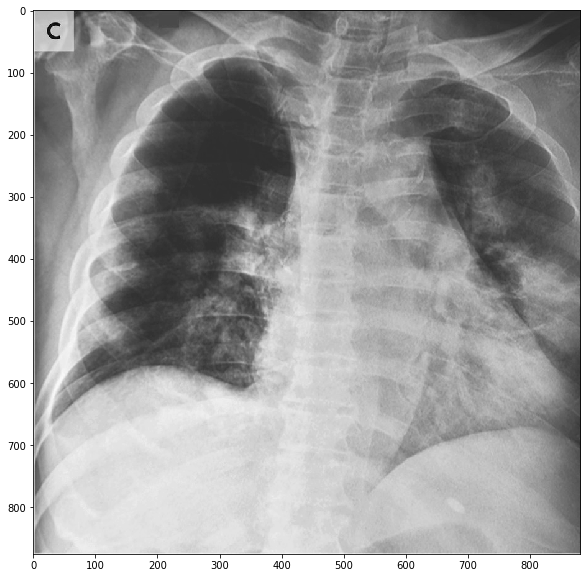

In [199]:
#creating the dataset instance and printing an exmaple image
import matplotlib.pyplot as plt

ieee = COVID19_Dataset()
image1 = ieee.__getitem__(2)['img']


plt.figure(figsize=(10,10))
plt.imshow(image1[0],cmap='gray')
print(image1)
len(ieee)

In [68]:
# creating data frame 
metadata_dir = os.path.join(thispath,'metadata.csv')
metadata = pd.read_csv(metadata_dir)
# what info do we have?
#print(metadata.columns)

print(metadata.head(1))
print(metadata.info())
# checking how many x-rays there are  in PA view 
xray =0
PA = 0
for i in range(len(metadata['modality'])):
    if metadata['modality'][i] == 'X-ray':
        xray +=1
    if metadata['view'][i] == 'PA' and metadata['modality'][i] == 'X-ray' :
        PA +=1 
    
print('\n', 'number of xrays:',xray,'\n','xray in PA:',PA )


   patientid  offset sex   age   finding survival intubated  \
0          2     0.0   M  65.0  COVID-19        Y       NaN   

  intubation_present went_icu needed_supplemental_O2  ...              date  \
0                NaN      NaN                    NaN  ...  January 22, 2020   

                                      location  folder  \
0  Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   

                                            filename                   doi  \
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   

                                                 url license  \
0  https://www.nejm.org/doi/full/10.1056/NEJMc200...     NaN   

                                  clinical_notes other_notes Unnamed: 27  
0  infiltrate in the upper lobe of the left lung         NaN         NaN  

[1 rows x 28 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 28 columns):
 #   Column                  Non-

In [10]:
# Get patient id for Xray PA view
ID = [] 
for i in range(len(metadata['patientid'])):
    if metadata['modality'][i] == 'X-ray' and metadata['view'][i] == 'PA' and metadata['finding'][i] == 'COVID-19':
        ID.append(i)

print(ID,'\n','Number of COVID-19 x-ray PA view images',len(ID))  

[0, 1, 2, 3, 4, 5, 7, 8, 20, 21, 22, 24, 26, 27, 29, 30, 31, 32, 33, 39, 40, 41, 42, 43, 48, 50, 51, 54, 57, 72, 81, 82, 84, 85, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 103, 107, 110, 111, 115, 116, 117, 118, 119, 120, 123, 126, 130, 131, 132, 133, 134, 135, 137, 143, 144, 146, 147, 148, 150, 152, 153, 157, 158, 159, 177, 179, 180, 182, 190, 191, 192, 209, 210, 211, 212, 213, 214, 215, 216, 220, 225, 250, 253, 254, 267, 282, 283, 284, 286, 287, 289, 290, 291, 293, 294, 297, 305, 306, 307, 308, 309, 310, 311, 312, 314, 315, 316, 317, 319, 320, 321, 324, 325, 326, 327, 331, 335, 338, 339, 341, 342, 345, 346, 347, 348, 349, 350, 351, 352, 353] 
 Number of COVID-19 x-ray PA view images 142


In [43]:
c = 0
p =0 
for i in range(len(metadata['patientid'])):
    if metadata['finding'][i] == 'COVID-19' and  metadata['modality'][i] == 'X-ray':
        c+=1
    if metadata['view'][i] == 'PA':
        p+=1
print('Number of covid-19 xrays',c)
#len(ieee) 
print('Number of PA views',p)
print('Length of ieee class object',len(ieee))

# 205 which means this IEEE only finds the PA view xrays as the number matches up, the number of COVID-19 cases that are in xray PA view is 142 according to the metadata

Number of covid-19 xrays 235
Number of PA views 205
Length of ieee class object 205


In [157]:
# From the class  Testing it out here a little bit
def getimages(metadata,idx):
    # defining variables which is a dictionary that has the types of penumonias as keys and the diseases as str in a list  
    mapping = dict()
    mapping["Pneumonia"] = pneumonias
    mapping["Viral Pneumonia"] = ["COVID-19", "SARS", "MERS"]
    mapping["Bacterial Pneumonia"] = ["Streptococcus", "Klebsiella", "Chlamydophila", "Legionella"]
    mapping["Fungal Pneumonia"] = ["Pneumocystis"]

    # creates label array, since only interested in COVID they will all be 1 
    labels = []
    pathologies = ['COVID-19']
    
  
    for pathology in pathologies:                            #useless but kept same architecture
        mask = metadata["finding"].str.contains(pathology) 
        if pathology in mapping:                             # if the patholgy in quesiton so if its pneumonia or any of the keys wihtin the pathologies key, for member
            for syn in mapping[pathology]:                   # in that list, print the dictionary mapping to that object and then use ior makes sure it contains that value
                print("mapping", syn)                        # print the mapping, then add the labels list where it adds 1 if thats the label and 0 if it doesnt according to pathologies list 
                mask |= metadata["finding"].str.contains(syn)
        labels.append(mask.values)                            # so just adds to the mask if its true a 1 or a 0 and then makes it an array and a float value 
    labels = np.asarray(labels).T
    labels = labels.astype(np.float32)                       # makes them a float in the list in our case only has 1 value for COVID-19 

    imgpath = os.path.join(thispath+'/images')                # makes path for images and then imgid is the index that is put in the function (location) img path just gives you the image from the filename
    imgid = metadata['filename'].iloc[idx]                    
    img_path = os.path.join(imgpath, imgid)
    #print(img_path)
    img = imread(img_path)
    img = normalize(img, 255) # bins  

    # Check that images are 2D arrays
    if len(img.shape) > 2:
        img = img[:, :, 0]
    if len(img.shape) < 2:
        print("error, dimension lower than 2 for image")
    # Add color channel
    img = img[None, :, :]                    
    #if self.data_aug is not None:             # might be useful if we are going to do data augmentation 
        #img = self.data_aug(img)
    result = {"img":img, "lab":labels[idx], "idx":idx}
    return result 



[0.]


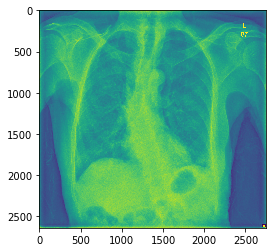

In [158]:
metadata_dir = os.path.join(thispath,'metadata.csv')
metadata = pd.read_csv(metadata_dir)

image1 = getimages(metadata,204)
print(image1['lab'])
plt.imshow(image1['img'][0])

In [382]:
def normalize(sample, maxval):
    """Scales images to be roughly [-255 255]."""
    sample = (2*(sample.astype(np.uint8) / maxval)-1)*1024
    #sample = sample / np.std(sample)
    #sample = (sample+1024)
    #sample= sample.astype(np.uint8)
    return sample
 

def getimage(idx):
    # defining variables which is a dictionary that has the types of penumonias as keys and the diseases as str in a list  
    # creates label array, since only interested in COVID they will all be 1 
    metadata_dir = os.path.join(thispath,'metadata.csv')
    metadata = pd.read_csv(metadata_dir)
    labels = []
    
    mask = metadata["finding"].str.contains('COVID-19') 
    labels.append(mask.values)   
                                                            #if pathologies[0] == 'COVID-19':  # so just adds to the mask if its true a 1 or a 0 and then makes it an array and a float value 
    labels = np.asarray(labels).T
    labels = labels.astype(np.float32)                       # makes them a float in the list in our case only has 1 value for COVID-19 

    imgpath = os.path.join(thispath+'/images')                # makes path for images and then imgid is the index that is put in the function (location) img path just gives you the image from the filename
    imgid = metadata['filename'].iloc[idx]                    
    img_path = os.path.join(imgpath, imgid)
    url = metadata['url'][idx]
    #print(img_path)
    img = imread(img_path)
    img = normalize(img, 255) # bins  
    
    # Check that images are 2D arrays
    if len(img.shape) > 2:
        img = img[:, :, 0]
    if len(img.shape) < 2:
        print("error, dimension lower than 2 for image")
    # Add color channel
    #img = img[None, :, :]                    
    #if self.data_aug is not None:             # might be useful if we are going to do data augmentation 
        #img = self.data_aug(img)
    result = {"img":img, "lab":labels[idx], "idx":idx, 'url':url}
    imsave('./COVID-19_Positive/{}.png'.format(idx),result['img'])

    return result 



In [389]:
# Saving all the images for COVID-19 in one cell 
# Get patient id for Xray PA view
ID = [] 
for i in range(len(metadata['patientid'])):
    if metadata['modality'][i] == 'X-ray' and metadata['view'][i] == 'PA' and metadata['finding'][i] == 'COVID-19':
        ID.append(i)
# save the COVID + images
image_info = []
for i in ID:
    result = getimage(i)
    image_info.append(result)

print(len(image_info))


Lossy conversion from float64 to uint8. Range [-895.4980392156863, 1024.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-815.1843137254903, 1024.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-839.278431372549, 1024.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-847.3098039215686, 1024.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-550.1490196078431, 1024.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-534.0862745098038, 1024.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-807.1529411764706, 1024.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversi

142


In [397]:
array = [] 
urls = [] 
label = [] 
index = []
for i in range(len(image_info)):
    array.append(image_info[i]['img'])
    label.append(image_info[i]['lab'])
    urls.append(image_info[i]['url'])
    index.append(image_info[i]['idx'])                         
    

In [401]:
df = {'Index': index,'Label':label,'Array':array,'urls':urls}
covid_positive = pd.DataFrame(data=df)


In [409]:
covid_positive.to_csv('covid_positive.csv',header=True,index=False)
covid_positive.head(5)


,Index,Label,Array,urls
0,0,[1.0],"[[1024.0, 1015.9686274509804, 1007.93725490196...",https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,1,[1.0],"[[1007.9372549019608, 991.8745098039215, 983.8...",https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,[1.0],"[[1024.0, 983.8431372549019, 783.0588235294117...",https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,3,[1.0],"[[1007.9372549019608, 1015.9686274509804, 999....",https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,[1.0],"[[-477.8666666666667, -485.89803921568625, -48...",https://www.nejm.org/doi/full/10.1056/NEJMc200...
